In [144]:
from datetime import datetime
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
import pickle
from sklearn.preprocessing import StandardScaler

# Filter out unnecceessary data

In [145]:
df = pd.read_csv("../dataset.csv", index_col="ts", parse_dates = True)
df.head()

id    light  temperature  soil_moisture  humidity  \
ts                                                                       
2025-04-01 21:15:00   1  34.3262      33.3125         3262.0        84   
2025-04-01 21:30:00   2  33.9057      33.4688         3232.5        84   
2025-04-01 21:45:00   3  33.2979      33.5938         3218.0        85   
2025-04-01 22:00:00   4  33.6201      33.3281         3211.0        85   
2025-04-01 22:15:00   5  33.2979      33.3438         3203.0        85   

                     api_temp  precipitation  cloud_cover  
ts                                                         
2025-04-01 21:15:00      27.9            0.1          100  
2025-04-01 21:30:00      27.8            0.1          100  
2025-04-01 21:45:00      27.8            0.1          100  
2025-04-01 22:00:00      27.6            0.0          100  
2025-04-01 22:15:00      27.6            0.0          100

In [146]:
df = df.resample('6H').mean()
df.head()

/tmp/ipykernel_56167/291736663.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('6H').mean()


id      light  temperature  soil_moisture   humidity  \
ts                                                                            
2025-04-01 18:00:00   6.0  30.485055    33.485800    3211.045455  83.909091   
2025-04-02 00:00:00  13.0  22.453833    33.401067    3192.000000  86.000000   
2025-04-02 06:00:00  23.5  26.436983    33.516494    3200.916667  65.722222   
2025-04-02 12:00:00  44.5  24.979783    33.541017    3151.187500  44.000000   
2025-04-02 18:00:00  68.5  30.427021    34.188162    3130.416667  76.000000   

                      api_temp  precipitation  cloud_cover  
ts                                                          
2025-04-01 18:00:00  28.200000       0.027273    96.363636  
2025-04-02 00:00:00  28.300000       0.000000    72.000000  
2025-04-02 06:00:00  31.611111       0.000000    55.777778  
2025-04-02 12:00:00  34.504167       0.000000   100.000000  
2025-04-02 18:00:00  29.166667       0.000000   100.000000

# EDA

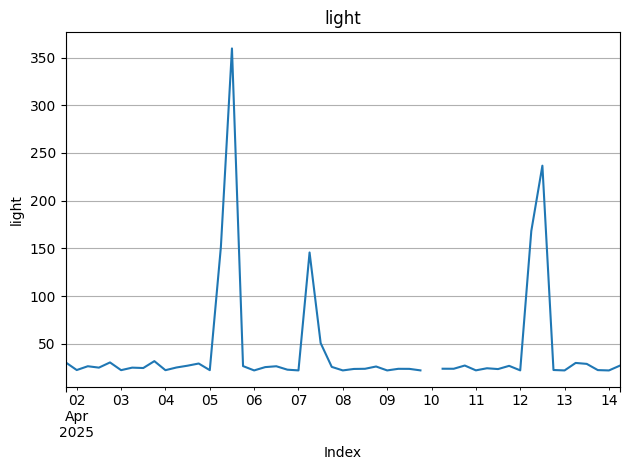

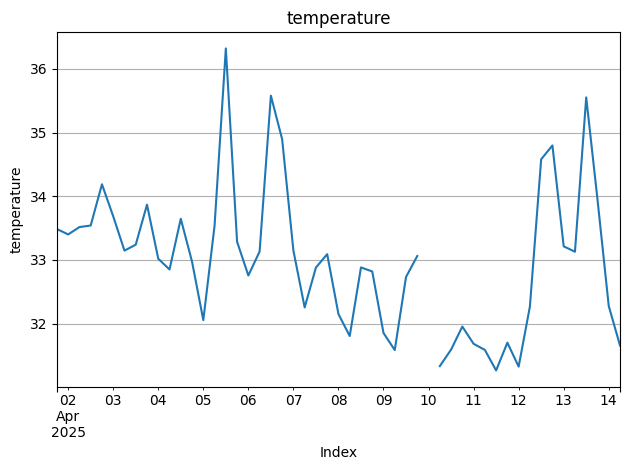

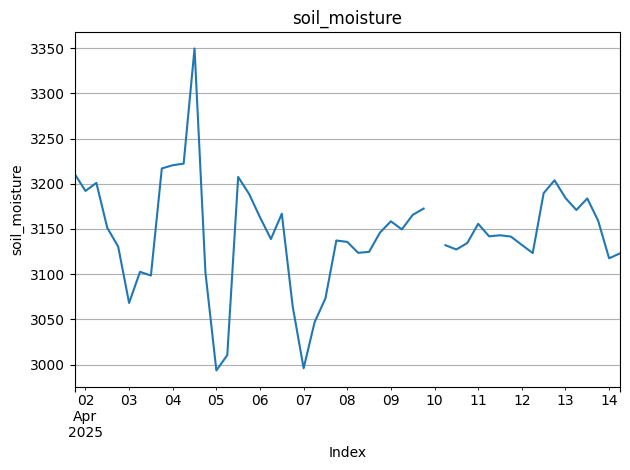

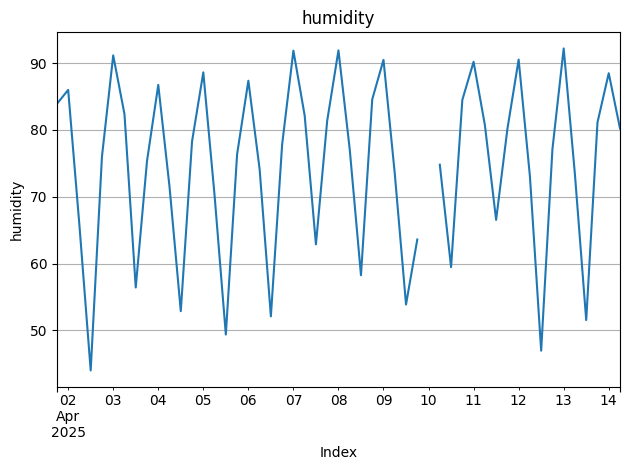

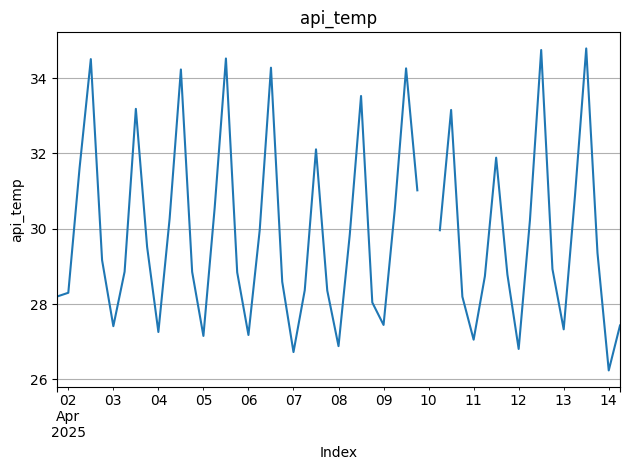

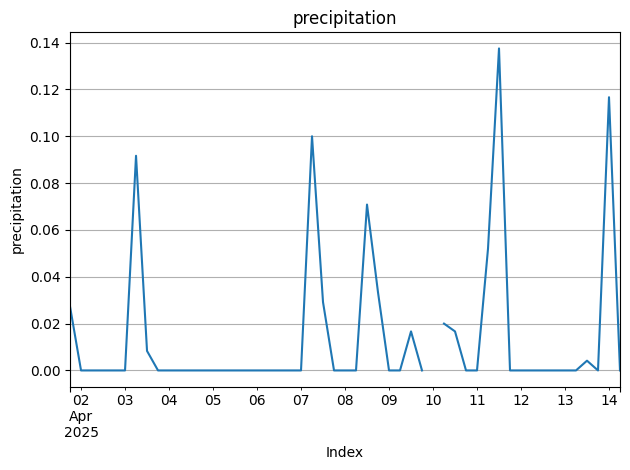

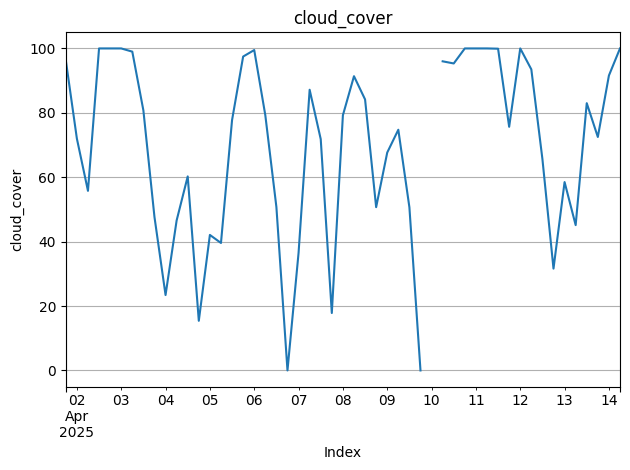

In [147]:
for column in df.columns:
    if column == "id":
        continue
    plt.figure()  # Create a new figure for each plot
    df[column].plot()
    plt.title(column)
    plt.xlabel("Index")  # or "Date" if it's time series
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Axes: >

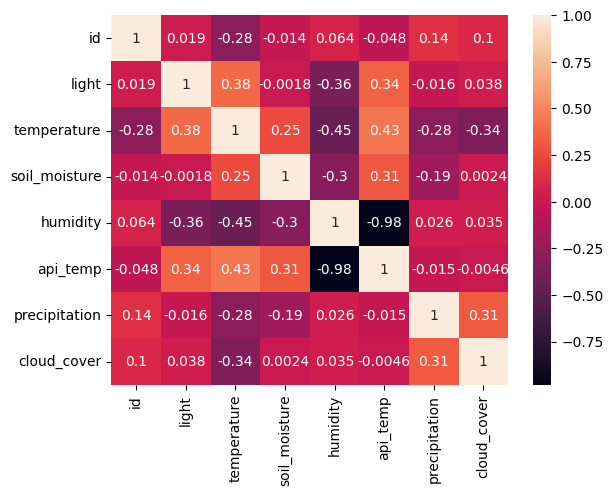

In [148]:
sns.heatmap(df.corr(),annot=True)

In [149]:
df["soil_moisture"].diff().dropna()

ts
2025-04-02 00:00:00    -19.045455
2025-04-02 06:00:00      8.916667
2025-04-02 12:00:00    -49.729167
2025-04-02 18:00:00    -20.770833
2025-04-03 00:00:00    -62.333333
2025-04-03 06:00:00     34.437500
2025-04-03 12:00:00     -4.125000
2025-04-03 18:00:00    118.500000
2025-04-04 00:00:00      3.562500
2025-04-04 06:00:00      1.750000
2025-04-04 12:00:00    127.437500
2025-04-04 18:00:00   -248.062500
2025-04-05 00:00:00   -108.145833
2025-04-05 06:00:00     16.916667
2025-04-05 12:00:00    197.125000
2025-04-05 18:00:00    -18.805254
2025-04-06 00:00:00    -25.840580
2025-04-06 06:00:00    -24.037879
2025-04-06 12:00:00     27.990260
2025-04-06 18:00:00   -102.744048
2025-04-07 00:00:00    -68.166667
2025-04-07 06:00:00     50.680417
2025-04-07 12:00:00     26.736250
2025-04-07 18:00:00     63.895833
2025-04-08 00:00:00     -1.562500
2025-04-08 06:00:00    -12.083333
2025-04-08 12:00:00      1.083333
2025-04-08 18:00:00     21.354167
2025-04-09 00:00:00     12.437500
2025-04-09 

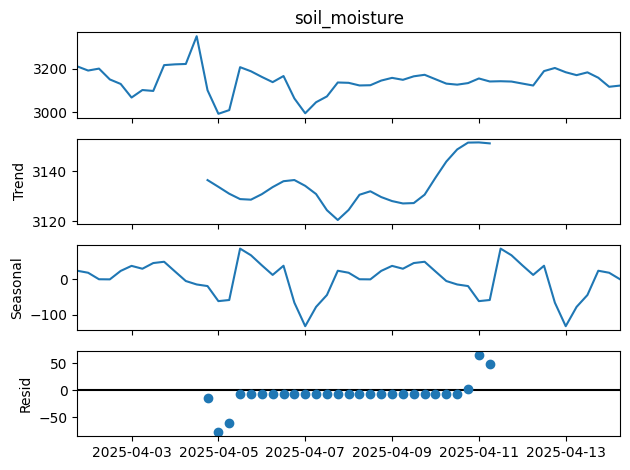

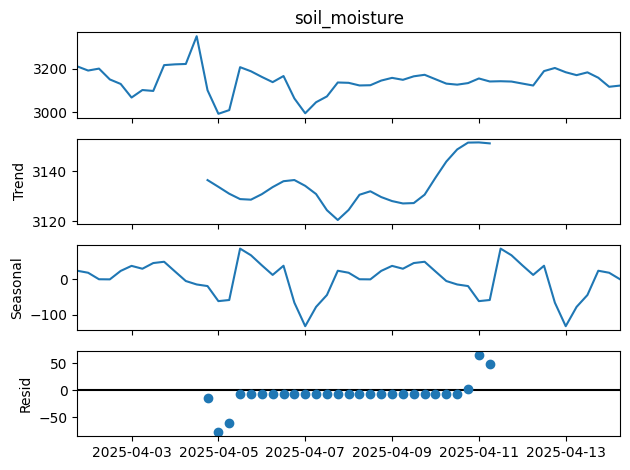

In [150]:
seasonal_decompose(df["soil_moisture"].interpolate(), model="additive").plot()


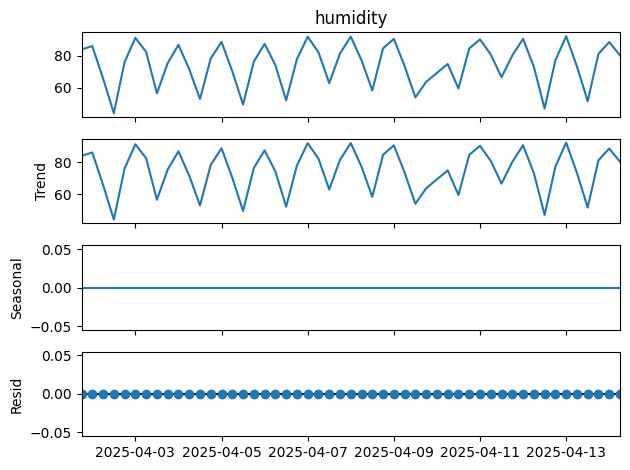

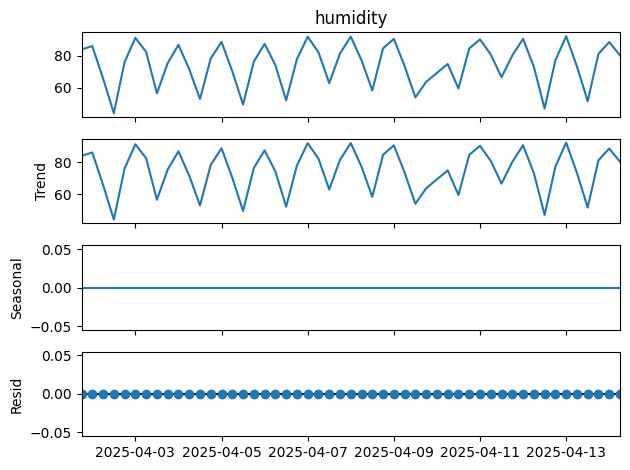

In [151]:
seasonal_decompose(df["humidity"].interpolate(), model="additive", period=1).plot()

## Find D parameter

In [152]:
result = adfuller(df["soil_moisture"].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -1.824287174764549
p-value: 0.3684721817603193
Critial Values:
   1%, -3.5925042342183704
Critial Values:
   5%, -2.931549768951162
Critial Values:
   10%, -2.60406594375338


Since p-value is less than 0.05, the data is stationary and no differencing is needed.

Therefore, we use d=0.

## Find P parameter

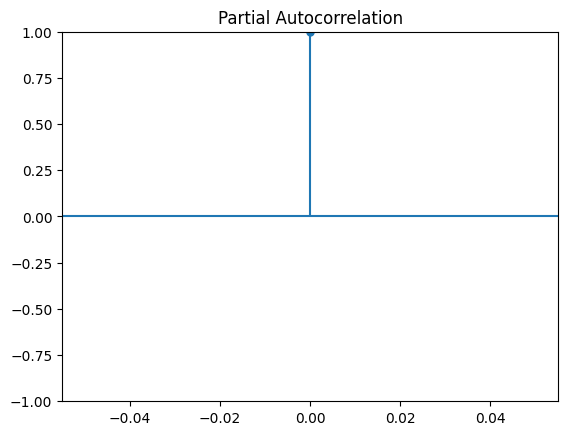

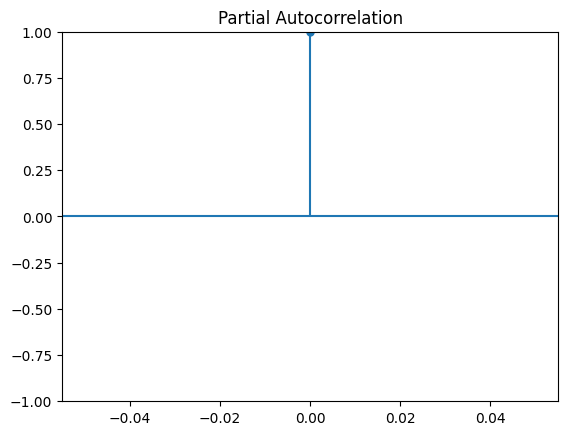

In [153]:
plot_pacf(df["soil_moisture"])


There are 1 exceptionally high bars, therefore, p=1

## Find Q parameter

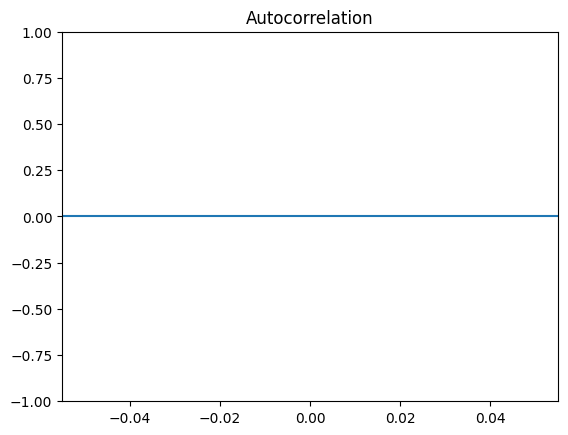

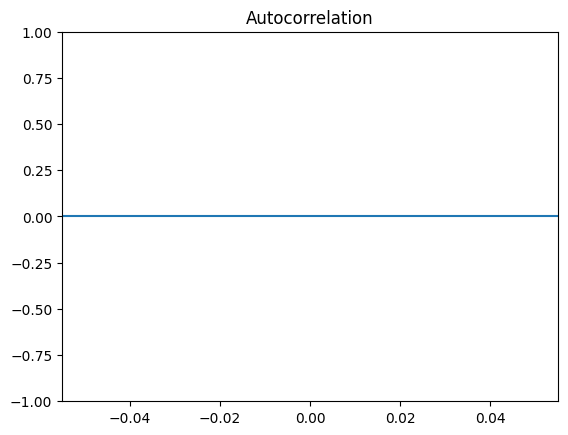

In [154]:
plot_acf(df["soil_moisture"])

There are 1 exceptionally high bars, therefore, q=1

# Pre-Processing

## Separate the test and train data

In [155]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end-timedelta(days=1)]
test_data = df[train_end:test_end]
# test_data = df[train_end + timedelta(days=1):test_end]
print(train_data)
print(test_data)


                        id       light  temperature  soil_moisture   humidity  \
ts                                                                              
2025-04-01 18:00:00    6.0   30.485055    33.485800    3211.045455  83.909091   
2025-04-02 00:00:00   13.0   22.453833    33.401067    3192.000000  86.000000   
2025-04-02 06:00:00   23.5   26.436983    33.516494    3200.916667  65.722222   
2025-04-02 12:00:00   44.5   24.979783    33.541017    3151.187500  44.000000   
2025-04-02 18:00:00   68.5   30.427021    34.188162    3130.416667  76.000000   
2025-04-03 00:00:00   92.5   22.328229    33.685542    3068.083333  91.166667   
2025-04-03 06:00:00  116.5   24.968662    33.147146    3102.520833  82.375000   
2025-04-03 12:00:00  140.5   24.560179    33.240233    3098.395833  56.416667   
2025-04-03 18:00:00  164.5   31.776358    33.868488    3216.895833  75.333333   
2025-04-04 00:00:00  188.5   22.290837    33.019529    3220.458333  86.750000   
2025-04-04 06:00:00  212.5  

In [156]:
train_data.head()

id      light  temperature  soil_moisture   humidity  \
ts                                                                            
2025-04-01 18:00:00   6.0  30.485055    33.485800    3211.045455  83.909091   
2025-04-02 00:00:00  13.0  22.453833    33.401067    3192.000000  86.000000   
2025-04-02 06:00:00  23.5  26.436983    33.516494    3200.916667  65.722222   
2025-04-02 12:00:00  44.5  24.979783    33.541017    3151.187500  44.000000   
2025-04-02 18:00:00  68.5  30.427021    34.188162    3130.416667  76.000000   

                      api_temp  precipitation  cloud_cover  
ts                                                          
2025-04-01 18:00:00  28.200000       0.027273    96.363636  
2025-04-02 00:00:00  28.300000       0.000000    72.000000  
2025-04-02 06:00:00  31.611111       0.000000    55.777778  
2025-04-02 12:00:00  34.504167       0.000000   100.000000  
2025-04-02 18:00:00  29.166667       0.000000   100.000000

In [157]:
test_data.head()

id      light  temperature  soil_moisture  humidity  \
ts                                                                            
2025-04-09 00:00:00  662.5  22.044396    31.854167    3158.416667    90.500   
2025-04-09 06:00:00  686.5  23.729654    31.586587    3149.458333    73.500   
2025-04-09 12:00:00  710.5  23.680588    32.733071    3165.520833    53.875   
2025-04-09 18:00:00  725.0  22.092880    33.062520    3172.500000    63.600   
2025-04-10 00:00:00    NaN        NaN          NaN            NaN       NaN   

                      api_temp  precipitation  cloud_cover  
ts                                                          
2025-04-09 00:00:00  27.445833       0.000000    67.666667  
2025-04-09 06:00:00  30.525000       0.000000    74.750000  
2025-04-09 12:00:00  34.258333       0.016667    50.666667  
2025-04-09 18:00:00  31.020000       0.000000     0.000000  
2025-04-10 00:00:00        NaN            NaN          NaN

In [158]:
train_data[["soil_moisture"]]

soil_moisture
ts                                
2025-04-01 18:00:00    3211.045455
2025-04-02 00:00:00    3192.000000
2025-04-02 06:00:00    3200.916667
2025-04-02 12:00:00    3151.187500
2025-04-02 18:00:00    3130.416667
2025-04-03 00:00:00    3068.083333
2025-04-03 06:00:00    3102.520833
2025-04-03 12:00:00    3098.395833
2025-04-03 18:00:00    3216.895833
2025-04-04 00:00:00    3220.458333
2025-04-04 06:00:00    3222.208333
2025-04-04 12:00:00    3349.645833
2025-04-04 18:00:00    3101.583333
2025-04-05 00:00:00    2993.437500
2025-04-05 06:00:00    3010.354167
2025-04-05 12:00:00    3207.479167
2025-04-05 18:00:00    3188.673913
2025-04-06 00:00:00    3162.833333
2025-04-06 06:00:00    3138.795455
2025-04-06 12:00:00    3166.785714
2025-04-06 18:00:00    3064.041667
2025-04-07 00:00:00    2995.875000
2025-04-07 06:00:00    3046.555417
2025-04-07 12:00:00    3073.291667
2025-04-07 18:00:00    3137.187500
2025-04-08 00:00:00    3135.625000

In [159]:
test_data['soil_moisture'].count()

8

In [160]:
test_data[['light', 'precipitation']]

light  precipitation
ts                                           
2025-04-09 00:00:00  22.044396       0.000000
2025-04-09 06:00:00  23.729654       0.000000
2025-04-09 12:00:00  23.680588       0.016667
2025-04-09 18:00:00  22.092880       0.000000
2025-04-10 00:00:00        NaN            NaN
2025-04-10 06:00:00  23.824460       0.020000
2025-04-10 12:00:00  23.791867       0.016667
2025-04-10 18:00:00  27.169396       0.000000
2025-04-11 00:00:00  22.121229       0.000000

# Train the model

Import the model to predict the exog values

In [161]:
# Import exog data predicting models 
with open('../exports/api_temp_sarima.pkl', 'rb') as file:
    api_temp_model = pickle.load(file)

with open('../exports/humidity_sarima.pkl', 'rb') as file:
    humidity_model = pickle.load(file)

with open('../exports/temperature_sarima.pkl', 'rb') as file:
    temperature_model = pickle.load(file)
    
with open('../exports/light_sarima.pkl', 'rb') as file:
    light_model = pickle.load(file)
    
with open('../exports/precipitation_sarima.pkl', 'rb') as file:
    precipitation_model = pickle.load(file)

In [162]:
light_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             light   No. Observations:                    8
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 3)   Log Likelihood                 -42.022
Date:                           Tue, 29 Apr 2025   AIC                             94.043
Time:                                   19:55:05   BIC                             94.440
Sample:                               04-01-2025   HQIC                            91.364
                                    - 04-08-2025                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.223      4.493      0.000       0.564       1.436
ma.L1         -0.9658      9.680     -0.100      0.921     -19.939      18.007
ar.S.L3       -0.9988      1.079     -0.926      0.355      -3.114       1.116
ma.S.L3        0.9763     10.786      0.091      0.928     -20.163      22.116
sigma2      1353.3963      0.010    1.4e+05      0.000    1353.377    1353.415
===================================================================================
Ljung-Box (L1) (Q):                   2.18   Jarque-Bera (JB):                 5.17
Prob(Q):                              0.14   Prob(JB):                         0.08
Heteroskedasticity (H):               1.73   Skew:                             1.71
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.15e+22. Standard errors may be unstable.
"""

In [163]:
# Predicting the data
forecast_steps = len(test_data)

# Get forecasts and rename columns immediately
exog_predictions = (
    precipitation_model.get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename('precipitation')
    .to_frame()
)

light_predictions = (
    light_model.get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename('light')
    .to_frame()
)

# temperature_predictions = (
#     temperature_model.get_forecast(steps=forecast_steps)
#     .predicted_mean
#     .rename('temperature')
#     .to_frame()
# )

# Combine exogenous variables
exog_predictions = pd.concat(
    [exog_predictions, light_predictions], 
    axis=1
)

# If using temperature:
# exog_predictions = pd.concat(
#     [exog_predictions, temperature_predictions], 
#     axis=1
# )

print(exog_predictions.columns)
print(test_data[['light', 'precipitation']])
exog_predictions.head()

Index(['precipitation', 'light'], dtype='object')
                         light  precipitation
ts                                           
2025-04-09 00:00:00  22.044396       0.000000
2025-04-09 06:00:00  23.729654       0.000000
2025-04-09 12:00:00  23.680588       0.016667
2025-04-09 18:00:00  22.092880       0.000000
2025-04-10 00:00:00        NaN            NaN
2025-04-10 06:00:00  23.824460       0.020000
2025-04-10 12:00:00  23.791867       0.016667
2025-04-10 18:00:00  27.169396       0.000000
2025-04-11 00:00:00  22.121229       0.000000


precipitation      light
2025-04-09       0.059648  43.768346
2025-04-10       0.106391  40.317933
2025-04-11       0.165445  62.120539
2025-04-12       0.197416  43.094808
2025-04-13       0.284098  46.507610

In [164]:
print("Training exog stats:")
print(train_data[['precipitation', 'light']].describe())

print("\nPrediction exog stats:")
print(exog_predictions.describe())

Training exog stats:
       precipitation       light
count      26.000000   26.000000
mean        0.009863   48.652829
std         0.026486   71.757186
min         0.000000   22.052842
25%         0.000000   22.546738
50%         0.000000   25.637452
75%         0.000000   30.141403
max         0.100000  359.524546

Prediction exog stats:
       precipitation      light
count       9.000000   9.000000
mean        0.339515  45.152668
std         0.236992  11.441189
min         0.059648  24.697234
25%         0.165445  40.317933
50%         0.284098  43.666983
75%         0.502342  46.507610
max         0.751234  62.120539


## Data Scaling

In [165]:
scaler = StandardScaler()
scaler.fit(train_data[['precipitation', 'light']])
train_exog_scaled = scaler.transform(train_data[['precipitation', 'light']])
train_exog_scaled = pd.DataFrame(train_exog_scaled, columns=['precipitation', 'light'], index=train_data.index)
prediction_exog_scaled = scaler.transform(exog_predictions[['precipitation', 'light']])
prediction_exog_scaled = pd.DataFrame(prediction_exog_scaled, columns=exog_predictions.columns, index=exog_predictions.index)

## Actual Prediction

In [166]:
prediction_exog_scaled

precipitation     light
2025-04-09       1.916892 -0.069418
2025-04-10       3.716689 -0.118454
2025-04-11       5.990492  0.191401
2025-04-12       7.221483 -0.078990
2025-04-13      10.559085 -0.030488
2025-04-14      14.908374 -0.340454
2025-04-15      18.962321 -0.070858
2025-04-16      22.414646 -0.119779
2025-04-17      28.545590  0.189345

In [167]:
train_data['soil_moisture']

ts
2025-04-01 18:00:00    3211.045455
2025-04-02 00:00:00    3192.000000
2025-04-02 06:00:00    3200.916667
2025-04-02 12:00:00    3151.187500
2025-04-02 18:00:00    3130.416667
2025-04-03 00:00:00    3068.083333
2025-04-03 06:00:00    3102.520833
2025-04-03 12:00:00    3098.395833
2025-04-03 18:00:00    3216.895833
2025-04-04 00:00:00    3220.458333
2025-04-04 06:00:00    3222.208333
2025-04-04 12:00:00    3349.645833
2025-04-04 18:00:00    3101.583333
2025-04-05 00:00:00    2993.437500
2025-04-05 06:00:00    3010.354167
2025-04-05 12:00:00    3207.479167
2025-04-05 18:00:00    3188.673913
2025-04-06 00:00:00    3162.833333
2025-04-06 06:00:00    3138.795455
2025-04-06 12:00:00    3166.785714
2025-04-06 18:00:00    3064.041667
2025-04-07 00:00:00    2995.875000
2025-04-07 06:00:00    3046.555417
2025-04-07 12:00:00    3073.291667
2025-04-07 18:00:00    3137.187500
2025-04-08 00:00:00    3135.625000
Freq: 6h, Name: soil_moisture, dtype: float64

In [168]:
model = SARIMAX(
    endog=train_data['soil_moisture'],
    exog=train_data[['precipitation', 'light']], # [['temperature','humidity','api_temp']],  # Use DataFrame/Series, not column name
    order=(0, 1, 0)
)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          soil_moisture   No. Observations:                   26
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -145.109
Date:                Tue, 29 Apr 2025   AIC                            296.218
Time:                        19:55:05   BIC                            299.875
Sample:                    04-01-2025   HQIC                           297.232
                         - 04-08-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
precipitation   -41.4596   1111.191     -0.037      0.970   -2219.353    2136.434
light             0.2800      0.171      1.642      0.101      -0.054       0.614
sigma2         6443.5819   1346.465      4.786      0.000    3804.559    9082.605
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 5.31
Prob(Q):                              0.77   Prob(JB):                         0.07
Heteroskedasticity (H):               1.11   Skew:                            -0.75
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [172]:
steps = int(test_data['soil_moisture'].count())
prediction = results.get_forecast(steps=steps , exog=exog_predictions[['precipitation', 'light']].iloc[:steps]).predicted_mean
prediction.columns = ['predicted']
prediction

2025-04-08 06:00:00    3139.231883
2025-04-08 12:00:00    3136.327648
2025-04-08 18:00:00    3139.985012
2025-04-09 00:00:00    3133.331452
2025-04-09 06:00:00    3130.693372
2025-04-09 12:00:00    3119.902305
2025-04-09 18:00:00    3120.849539
2025-04-10 00:00:00    3116.168198
Freq: 6h, Name: predicted_mean, dtype: float64

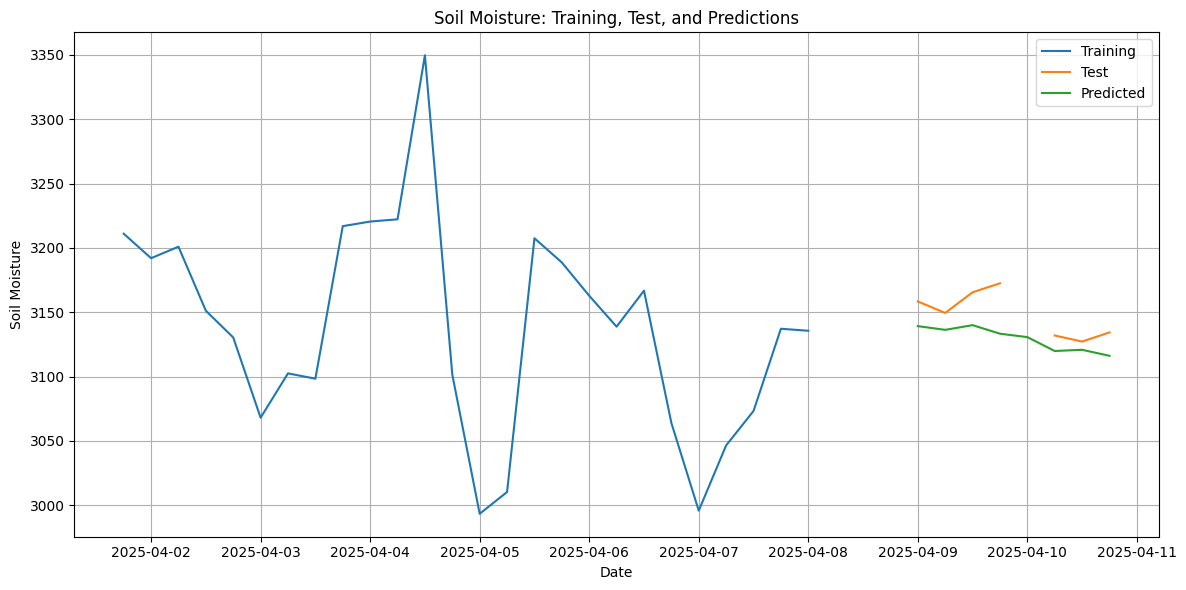

ValueError: Input contains NaN.

In [ ]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE : ", root_mean_squared_error(test_data['soil_moisture'], prediction))


## Exporting the trained model with Pickle for external uses.

**Warning** : Do not unpickle untrusted model because it might execute a malicious code hidden in the model file.

In [ ]:
with open('../exports/plant_water.pkl', 'wb') as file:
    pickle.dump(results, file)